<a href="https://colab.research.google.com/github/gstaros/SatelliteSegmentation/blob/UNet/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch
import copy


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown '1mQwBM1rcbBWwoxgpgJF3VnnUwy43fy9j'
!unzip drone_binary_segmentation.zip

Downloading...
From (original): https://drive.google.com/uc?id=1mQwBM1rcbBWwoxgpgJF3VnnUwy43fy9j
From (redirected): https://drive.google.com/uc?id=1mQwBM1rcbBWwoxgpgJF3VnnUwy43fy9j&confirm=t&uuid=f040201f-9b38-4320-bfde-17cf29813dd5
To: /content/drone_binary_segmentation.zip
100% 534M/534M [00:10<00:00, 48.7MB/s]
Archive:  drone_binary_segmentation.zip
  inflating: images_semantic/000.png  
  inflating: images_semantic/001.png  
  inflating: images_semantic/002.png  
 extracting: images_semantic/003.png  
 extracting: images_semantic/004.png  
 extracting: images_semantic/005.png  
 extracting: images_semantic/006.png  
 extracting: images_semantic/008.png  
  inflating: images_semantic/011.png  
  inflating: images_semantic/013.png  
 extracting: images_semantic/014.png  
 extracting: images_semantic/015.png  
  inflating: images_semantic/016.png  
  inflating: images_semantic/018.png  
  inflating: images_semantic/019.png  
  inflating: images_semantic/021.png  
 extracting: images_s

In [ ]:
class ImageSegmentationDataset(Dataset):
  def __init__(self, image_folder: str, mask_folder: str, split: str = "train", transform = None):

    self.image_folder = image_folder
    self.mask_folder = mask_folder
    self.split = split
    self.tranform = transform

    if split == "train":
      self.mask_files = sorted(os.listdir(self.mask_folder))[:400]
      self.image_files = sorted(os.listdir(self.image_folder))[:400]

    elif split == "val":
      self.mask_files = sorted(os.listdir(self.mask_folder))[400:500]
      self.image_files = sorted(os.listdir(self.image_folder))[400:500]

    elif split == "test":
      self.mask_files = sorted(os.listdir(self.mask_folder))[500:]
      self.image_files = sorted(os.listdir(self.image_folder))[500:]


  def __len__(self):
    return len(self.image_files)


  def __getitem__(self, idx):
    image_filename = self.image_files[idx]
    mask_filename = self.mask_files[idx]
    image_path = os.path.join(self.image_folder, image_filename)
    mask_path = os.path.join(self.mask_folder, mask_filename)

    pil_to_tensor = T.Compose([T.PILToTensor(), T.Resize((256, 256))])
    image = pil_to_tensor(Image.open(image_path))
    mask = pil_to_tensor(Image.open(mask_path))

    return image.type(torch.FloatTensor), mask.type(torch.FloatTensor)

In [ ]:
train_dataset = ImageSegmentationDataset(
    image_folder="/content/original_images",
    mask_folder="/content/images_semantic",
    split = "train",
    transform = None, # add more transform functions
)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

In [ ]:
def show_images(images):
  fig, axis = plt.subplots(1, len(images), figsize=(8, len(images) * 5))

  for idx, image in enumerate(images):
    image = image.type(torch.uint8)
    axis[idx].imshow(image.permute(1, 2, 0))
  plt.show()

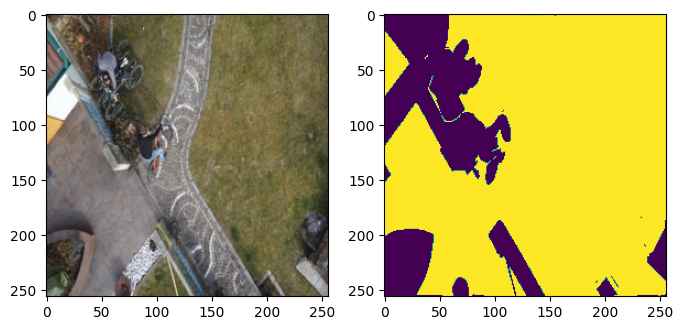

In [ ]:
show_images([train_dataset[3][0], train_dataset[3][1]])

In [ ]:
class Convolution(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.conv = Convolution(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.maxpool(x))


class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels //2, kernel_size=2, stride=2)
    self.conv = Convolution(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x1 = T.Resize((x2.shape[2], x2.shape[3]))(x1) # to have same image size for both layers

    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(UNet, self).__init__()
    self.in_conv = Convolution(n_channels, 64)
    self.down_conv1 = Down(64, 128)
    self.down_conv2 = Down(128, 256)
    self.down_conv3 = Down(256, 512)
    self.down_conv4 = Down(512, 1024)
    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)
    self.out_conv = Convolution(64, 1)

  def forward(self, x):
    conv1 = self.in_conv(x)
    conv2 = self.down_conv1(conv1)
    conv3 = self.down_conv2(conv2)
    conv4 = self.down_conv3(conv3)
    conv5 = self.down_conv4(conv4)

    up_conv4 = self.up1(conv5, conv4)
    up_conv3 = self.up2(up_conv4, conv3)
    up_conv2 = self.up3(up_conv3, conv2)
    up_conv1 = self.up4(up_conv2, conv1)
    out_conv = self.out_conv(up_conv1)

    return out_conv


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.sigmoid(self.conv3(x))
    x = torch.round(x)

    return x

In [ ]:
  def evaluate_model(model, data_loader, device):
    """
    Evaluates a trained model on a given dataset.

    Args:
        model: Model architecture to evaluate.
        data_loader: The data loader of the dataset to evaluate on.
        device: Device to use for training.
    Returns:
        accuracy: The accuracy on the dataset.

    """
    model.to(device)
    # Set model to evaluation mode (Remember to set it back to training mode in the training loop)
    model.eval()
    # Loop over the dataset and compute the accuracy. Return the accuracy
    # Remember to use torch.no_grad().
    batch_sizes, accs = [], []
    # calculate the metrics for each batch
    with torch.no_grad():
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            preds = model(X_test)
            batch_sizes.append(X_test.shape[0])

            correct = (preds == y_test).float().sum()
            total = preds.numel()
            acc = correct / total
            accs.append(acc.item())
    # calculate the average accuracy for the whole dataset, weighted by batch size
    accuracy = np.average(accs, weights=batch_sizes)

    return accuracy

In [ ]:
def predict(tensor, model):
    model.eval()
    model.to('cpu')
    tensor = tensor.type(torch.FloatTensor)
    predict = model(tensor.unsqueeze(0))
    predict = predict.clone().detach()
    return predict

Epoch 1/30
Train iou: 22.54% | Training loss: 0.5430


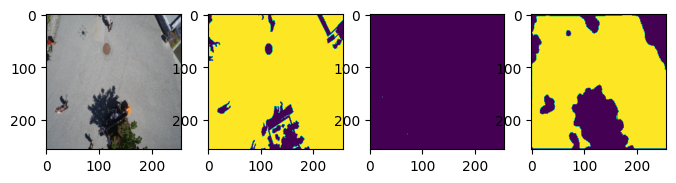

Epoch 2/30
Train iou: 23.87% | Training loss: 0.5200


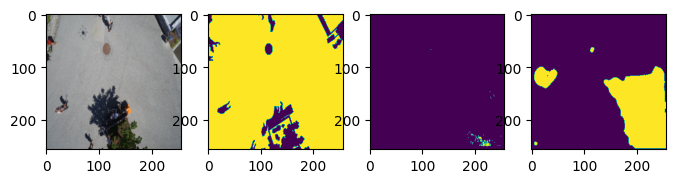

Epoch 3/30
Train iou: 22.61% | Training loss: 0.5113


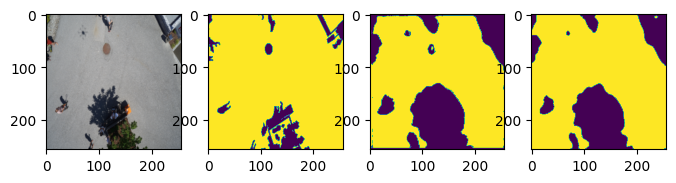

Epoch 4/30
Train iou: 22.51% | Training loss: 0.5026


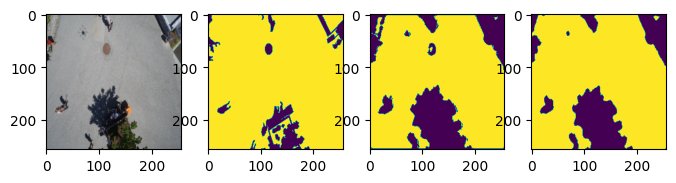

Epoch 5/30
Train iou: 20.48% | Training loss: 0.4960


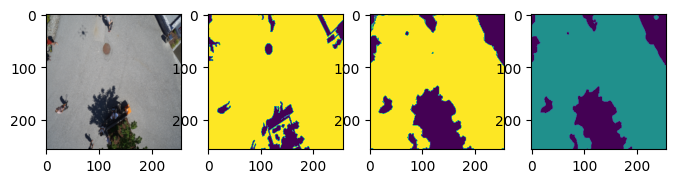

Epoch 6/30
Train iou: 23.80% | Training loss: 0.4893


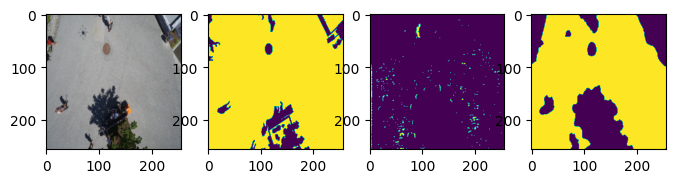

Epoch 7/30
Train iou: 23.38% | Training loss: 0.4789


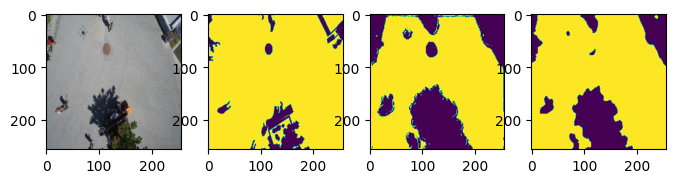

Epoch 8/30
Train iou: 23.08% | Training loss: 0.4730


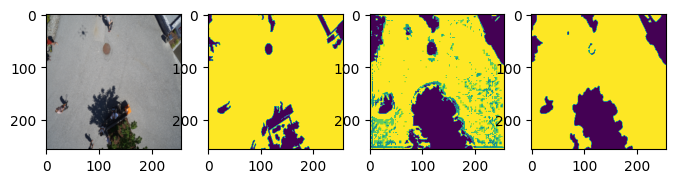

Epoch 9/30
Train iou: 19.43% | Training loss: 0.4678


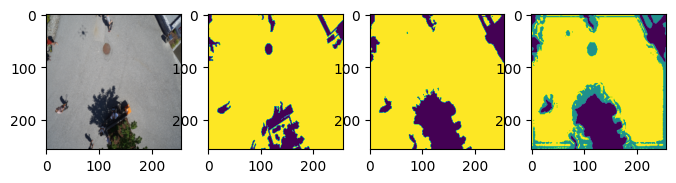

Epoch 10/30
Train iou: 22.24% | Training loss: 0.4630


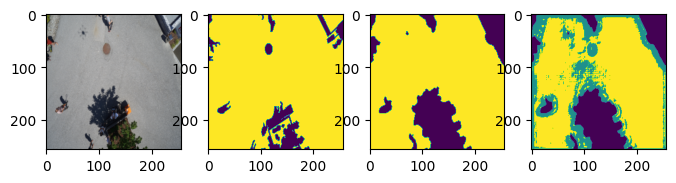

Epoch 11/30
Train iou: 23.84% | Training loss: 0.4564


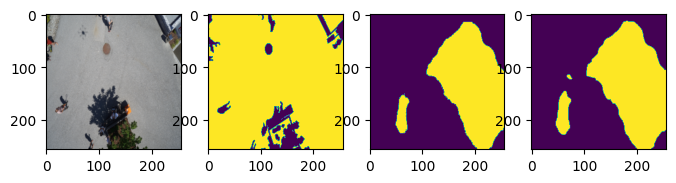

Epoch 12/30
Train iou: 23.16% | Training loss: 0.4500


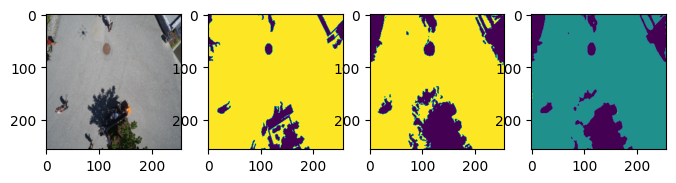

Epoch 13/30
Train iou: 22.67% | Training loss: 0.4486


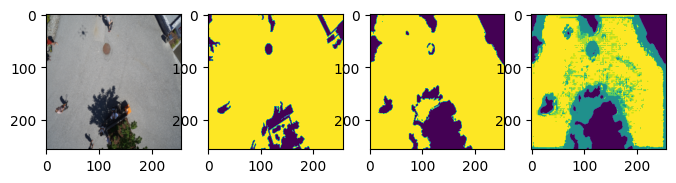

Epoch 14/30
Train iou: 18.09% | Training loss: 0.4402


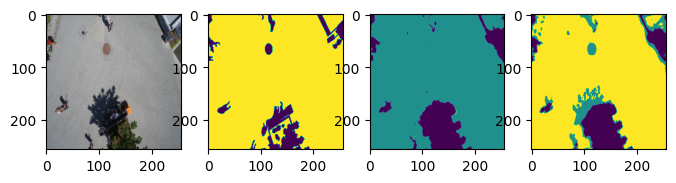

Epoch 15/30
Train iou: 23.83% | Training loss: 0.4351


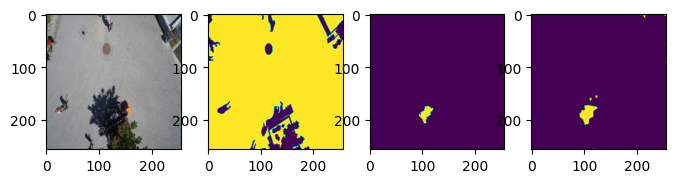

Epoch 16/30
Train iou: 20.31% | Training loss: 0.4294


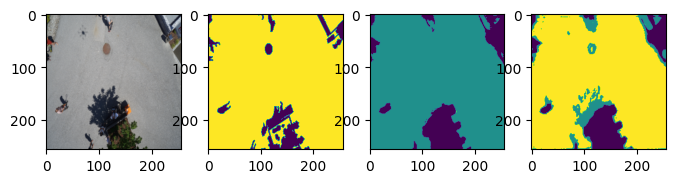

Epoch 17/30
Train iou: 20.15% | Training loss: 0.4210


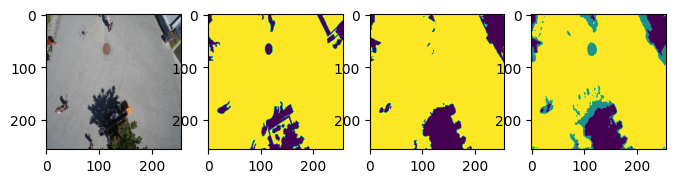

Epoch 18/30
Train iou: 20.56% | Training loss: 0.4184


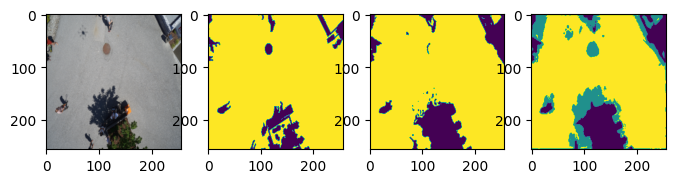

Epoch 19/30
Train iou: 19.22% | Training loss: 0.4125


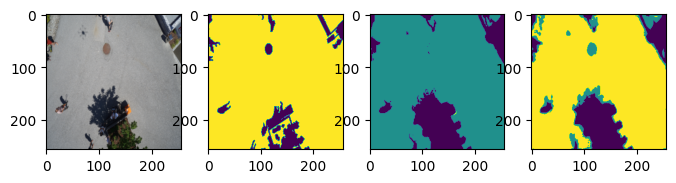

Epoch 20/30
Train iou: 23.14% | Training loss: 0.4109


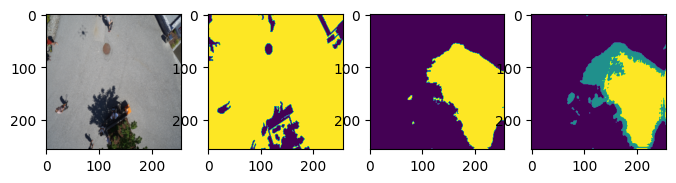

Epoch 21/30
Train iou: 23.08% | Training loss: 0.4057


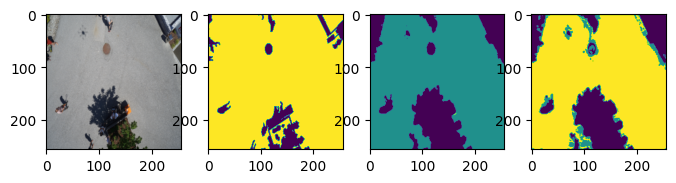

Epoch 22/30
Train iou: 15.85% | Training loss: 0.4040


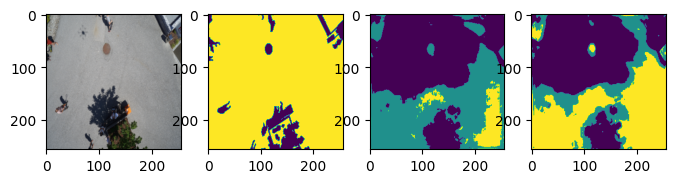

Epoch 23/30
Train iou: 21.50% | Training loss: 0.3946


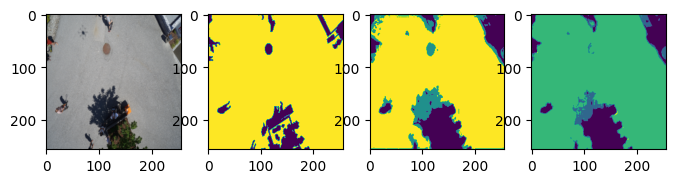

Epoch 24/30
Train iou: 23.04% | Training loss: 0.3915


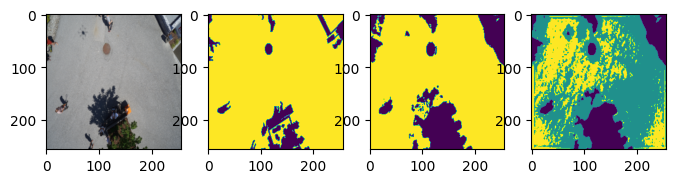

Epoch 25/30
Train iou: 23.29% | Training loss: 0.3887


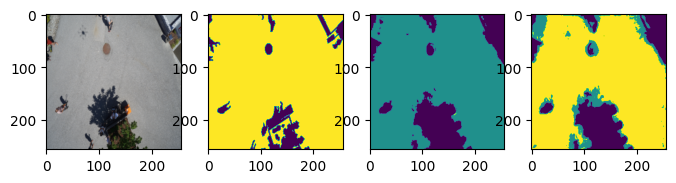

Epoch 26/30
Train iou: 23.18% | Training loss: 0.3813


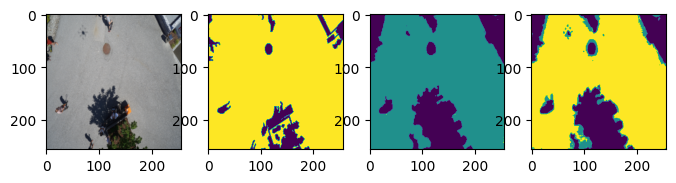

Epoch 27/30
Train iou: 20.34% | Training loss: 0.3781


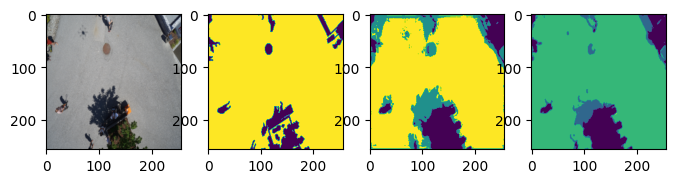

Epoch 28/30
Train iou: 16.97% | Training loss: 0.3750


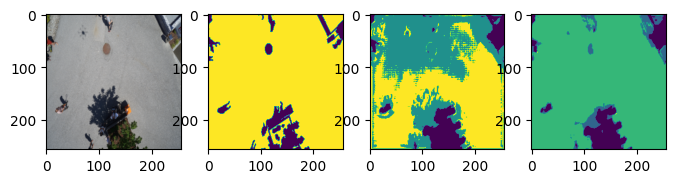

Epoch 29/30
Train iou: 20.56% | Training loss: 0.3704


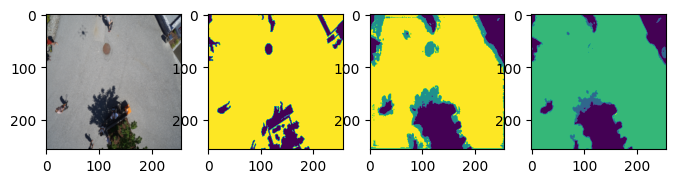

Epoch 30/30
Train iou: 10.79% | Training loss: 0.3716


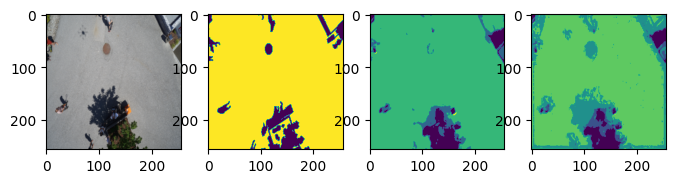

In [ ]:
# model = CNN()
model = UNet(3, 1)
model.to(device)

criterion = nn.BCEWithLogitsLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=0.001,
    alpha=0.9,
    eps=1e-8,
    weight_decay=0
)

best_acc = -1
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_losses_epoch, val_losses_epoch = [], []
    # train
    model.train()
    for (X_train, y_train) in train_dataloader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        pred_mask = model(X_train)
        loss = criterion(pred_mask, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.item())

    train_iou = evaluate_model(model, train_dataloader, device)
    # train_accs.append(train_acc)
    train_loss = np.mean(train_losses_epoch)
    # train_losses.append(train_loss)
    print(f'Train acc: {train_iou*100:.2f}% | Training loss: {train_loss:.4f}')

    output = predict(train_dataset[0][0], model=copy.deepcopy(model))
    show_images([train_dataset[0][0], train_dataset[0][1], output.squeeze(dim=0), torch.round(output.squeeze(dim=0))])
    plt.show()


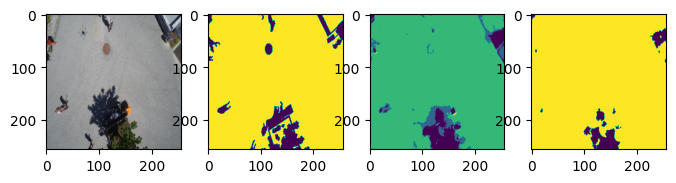

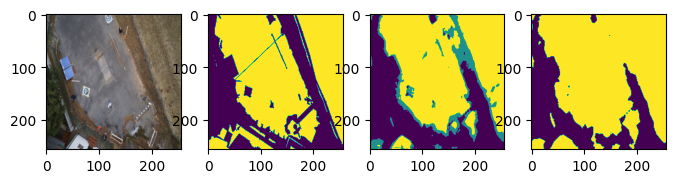

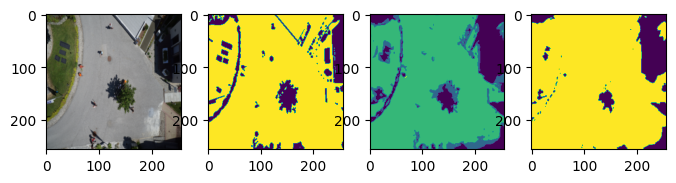

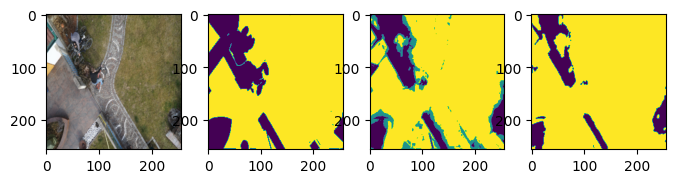

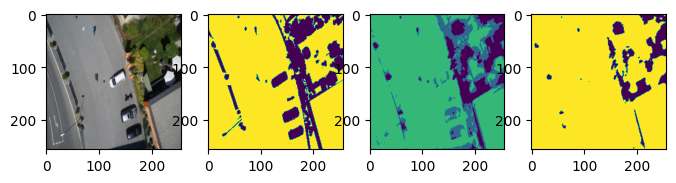

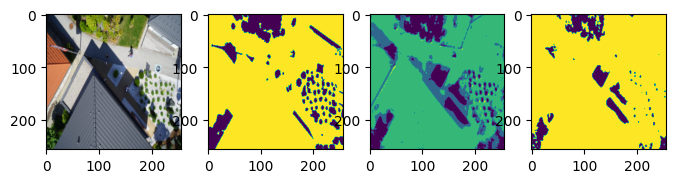

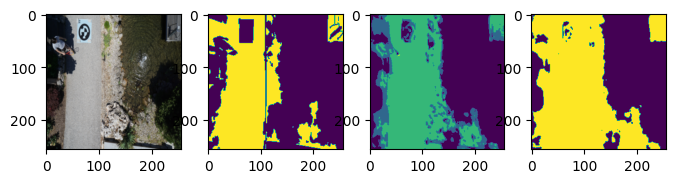

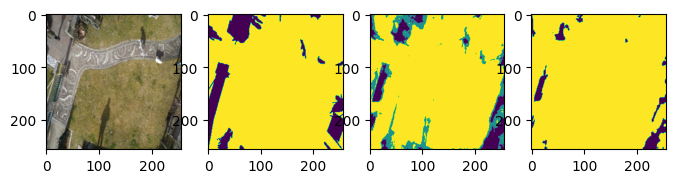

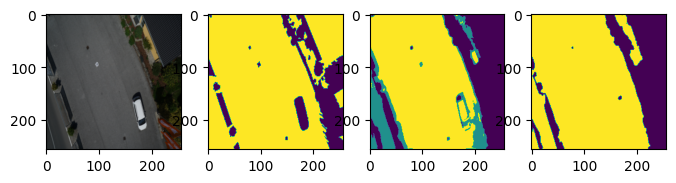

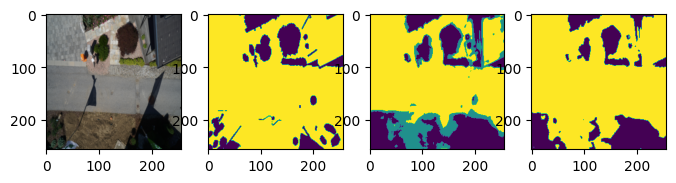

In [ ]:
for i in range(10):
  pred_image = train_dataset[i]
  output = predict(pred_image[0], model)
  show_images([pred_image[0], pred_image[1], output.squeeze(dim=0), torch.round(F.sigmoid(output.squeeze(dim=0)))])